# minmal example of kernel death

In [1]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

# modellist_orig= ['ACCESS-ESM1-5',  
#             'CESM2',    
#             'GFDL-ESM4',  
#             'GISS_E2.1',  
#             'NorESM2-LM',
#             'MPI-ESM1-2-LR',
#             'CNRM-ESM2-1',
#             'HadCM3LC-Bris']

modellist=['NorESM2-LM']

#runlist = ['flat10','flat10_zec','flat10_cdr']
runlist=['flat10_zec']
# use a wildcard to capture different ways the folders and runs are named across models
#runlist_wc = ['*lat10','*zec','*cdr']
runlist_wc=['*zec']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
# varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh']
#varlist=['cVeg']
varlist=varlist_load


In [2]:
data_dict={}

In [3]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)
#from xarray.coding.times import CFTimedeltaCoder
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True) #create time coder with cftime

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import glob


## notes on packages to add to this kernel
import nc_time_axis





# data location
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for r in range(len(runlist)):
        run = runlist_wc[r]
        print('loading run: ' +run)
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            print('loading variable: ' +var)
            
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            #----loop over filenames----#
            # some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file,decode_times=time_coder)
                else:
                    ds = xr.open_dataset(file,decode_times=time_coder)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            
            if model == 'NorESM2-LM':
                if 'PRECC' in dsmerge_f: #NorESM
                    dsmerge_f['pr']=dsmerge_f['PRECC']
                    if dsmerge_f['pr'].units == 'm/s':
                        dsmerge_f['pr']=dsmerge_f['pr']*(1e3)
                        dsmerge_f['pr'].attrs['units'] = 'kg m-2 s-1' #equivalent is mm/s
                



            
            #----check units and convert if necessary----#
            if var in dsmerge_f: 
                if model =='CESM2':
                    if dsmerge_f[var].units == 'gC/m^2/s':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    # stock variables

                
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])

                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray
            
            #----merge all variables into one dataset----#
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f],compat='override')

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                if (dsmerge_v['cLitter'].notnull().all()): #litter is sometimes missing. Would be good to make this more general but dealing with this problem for now.
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil']+dsmerge_v['cLitter'] 
                else: 
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil'] 
        
        #----save output to a dictionary----#
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v





loading model: NorESM2-LM
loading run: *zec
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding NorESM2-LM flat10_zec to dict


In [4]:
ds1=data_dict[model +'_flat10_zec']

ds1

<xarray.Dataset> Size: 985MB
Dimensions:    (time: 2520, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 20kB 1960-01-16 12:00:00 ... 2169-12-16 12:00:00
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 40kB 1960-01-01 00:00:00 ... 2170-01-01 00...
    lat_bnds   (time, lat, bnds) float64 4MB -90.0 -89.05 -89.05 ... 89.05 90.0
    lon_bnds   (time, lon, bnds) float64 6MB -1.25 1.25 1.25 ... 356.2 358.7
    cVeg       (time, lat, lon) float32 139MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cSoil      (time, lat, lon) float32 139MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cLitter    (time, lat, lon) float32 139MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cTot       (time, lat, lon) float32 139MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nbp        (time, lat, lon) float32 139MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    gpp        (time, lat, lon) float32 139MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rh         (time, lat, lon) float32 139MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1851-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               cVeg
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/e99c18ba-60ff-43a4-b80f-5c171bfa65d4

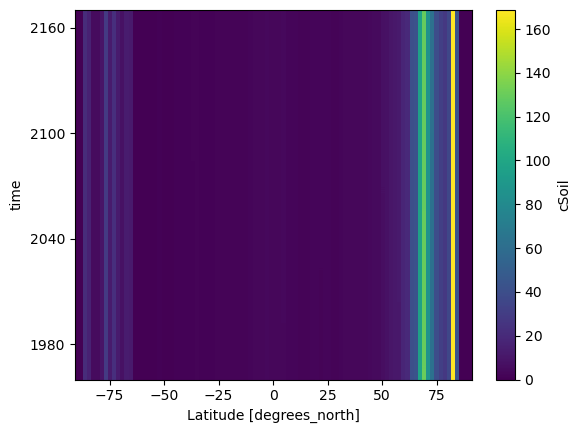

In [5]:
ds1['cSoil'].mean(dim='lon').plot()

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#from xarray.coding.times import CFTimedeltaCoder # only works with recent kernel 2025b
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True) #create time coder with cftime 

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import glob


In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'
model='NorESM2-LM'
run='flat10'

# single file
#filename='cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_185002-185912.nc'

#outputdir +model +'/' +run +'/*' +var +'_*.nc'

searchpath = outputdir +model +'/' +run +'/cVeg*.nc'
filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

filenamelist

array(['/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_185002-185912.nc',
       '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_186001-186912.nc',
       '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_187001-187912.nc',
       '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_188001-188912.nc',
       '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_189001-189912.nc',
       '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_190001-190912.nc',
       '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-LM_flat10_r1i1p1f1_gn_191001-191912.nc',
       '/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/flat10/cVeg_Lmon_NorESM2-L

In [3]:

#----loop over filenames----#
# some variables are stored in multiple files
# this should be possible with xr.open_mfdataset but it isn't loading all of time points
for f in range(len(filenamelist)):
    file = filenamelist[f]
    if f==0:
        dsmerge_f = xr.open_dataset(file,decode_times=time_coder)
    else:
        ds = xr.open_dataset(file,decode_times=time_coder)
        dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

In [4]:
#time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

#ds0=dsmerge_f = xr.open_dataset(file,decode_times=time_coder)
                                
##ds0=dsmerge_f = xr.open_dataset(file, use_cftime=True,decode_timedelta=CFTimedeltaCoder())


In [5]:
ds0 = dsmerge_f

ds0

<xarray.Dataset> Size: 106MB
Dimensions:    (time: 1799, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 14kB 1850-02-15 00:00:00 ... 1999-12-16 12:00:00
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 29kB 1850-02-01 00:00:00 ... 2000-01-01 00...
    lat_bnds   (time, lat, bnds) float64 3MB -90.0 -89.05 -89.05 ... 89.05 90.0
    lon_bnds   (time, lon, bnds) float64 4MB -1.25 1.25 1.25 ... 356.2 358.7
    cVeg       (time, lat, lon) float32 99MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1851-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               cVeg
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/0cb7c5f5-4b67-43dd-8f6f-c9376572aadb

In [6]:
ty=ds0['time'].dt.year
tyindx=ty-ty[0]+1

In [7]:
tyindx

<xarray.DataArray 'year' (time: 1799)> Size: 14kB
array([  1,   1,   1, ..., 150, 150, 150])
Coordinates:
  * time     (time) object 14kB 1850-02-15 00:00:00 ... 1999-12-16 12:00:00

In [8]:
import pickle

In [9]:
# must use NPL 2025b (not a 2023 version)

field = pickle.load(open('NorESM2-LM_2D_TOTVEGC_ann_drift.pkl','rb'))

# units are  [g C m-2 yr-1] 

In [10]:
# make xarray dataarrays to make it easier to apply to time dimensions

# for flat10, starts at 1850
adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'lat': ds0.lat, 'lon':ds0.lon})##,unit={'g C m-2 yr-1'})
##time_vector = xr.DataArray(np.arange(len(ds0.time)), dims='time', coords={'time': ds0.time})
ty=ds0['time'].dt.year
tyindx=ty-ty[0]+1
#time_vector = xr.DataArray(tyindx, dims='time', coords={'time': ds0.time})

ds0_adj = adj_matrix* tyindx
ds0_adj.attrs['units'] = 'kg m-2 s-1'

ds0_adj

<xarray.DataArray (lat: 96, lon: 144, time: 1799)> Size: 199MB
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 14kB 1850-02-15 00:00:00 ... 1999-12-16 12:00:00
Attributes:
    units:    kg m-2 s-1

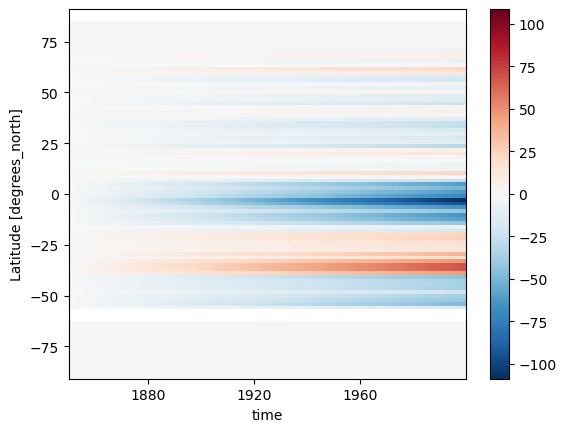

In [11]:
ds0_adj.mean(dim='lon').plot()